# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

1. Download the Solar Sunspot Dataset

In [9]:
# Load the sunspot dataset
filePath = 'sunspot_data.csv'
data = pd.read_csv(filePath)

In [10]:
# Display the first few rows
data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [11]:
# Filter and preprocess the dataset to focus on "Number of Sunspots"
data = data[data['Number of Sunspots'] >= 0]  # Remove negative values or missing entries
sunspots = data['Number of Sunspots'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
sunspots_normalized = scaler.fit_transform(sunspots)

In [12]:
print(f"Filtered data shape: {data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Sunspots shape: (70471, 1)


2. Plot the Dataset Using Matplotlib

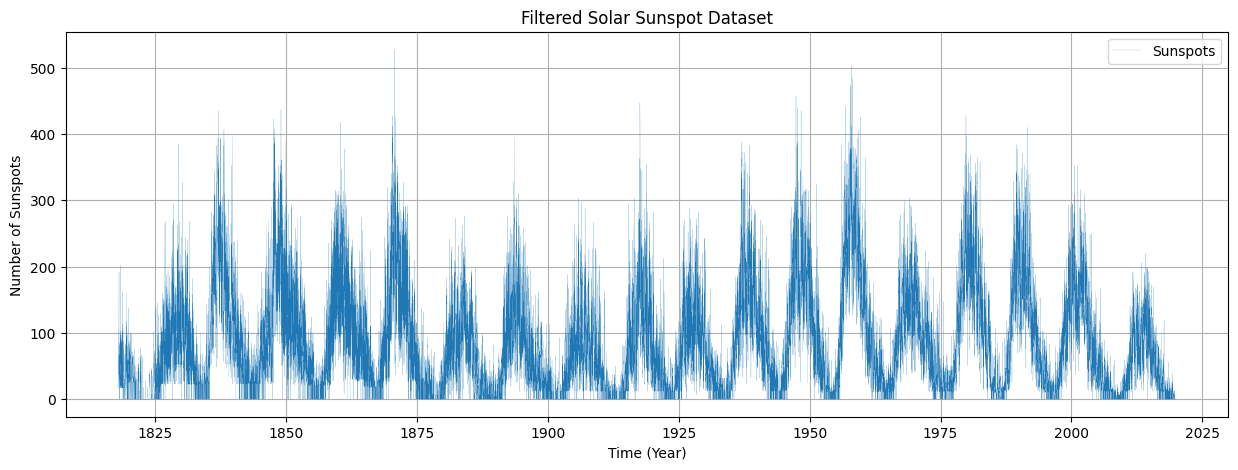

In [13]:
# Plot the dataset
plt.figure(figsize=(15, 5))
plt.plot(data['Date In Fraction Of Year'], sunspots, label='Sunspots', linewidth = 0.1)
plt.title('Filtered Solar Sunspot Dataset')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

---

In [14]:
!pip install torch

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Create windowed dataset
def create_windowed_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [17]:
window_size = 12  # You can experiment with this value
X, y = create_windowed_dataset(sunspots_normalized, window_size)

In [18]:
# Convert the data to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [19]:
# Modify the LSTM class to include dropout for regularization
class SunspotLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(SunspotLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.dropout = nn.Dropout(p=0.2)  # Adding dropout with 20% probability
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        lstm_out = self.dropout(lstm_out)  # Apply dropout to the LSTM output
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [20]:
# Hyperparameters
learning_rate = 0.0001 # Before was 0.001
weight_decay = 1e-5  # NEW parameters. Apply weight decay (L2 regularization)
epochs = 100  # You can increase this value for better training
input_size = 1
hidden_layer_size = 50
output_size = 1

In [21]:
# Initialize the model, loss function, and optimizer
model = SunspotLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Before
model = SunspotLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Apply weight decay

In [22]:
# Training loop with gradient clipping
losses = []
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()

        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    losses.append(single_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

Epoch 0, Loss: 2.803127472361666e-07
Epoch 10, Loss: 7.140579691622406e-05
Epoch 20, Loss: 0.0003046165802516043
Epoch 30, Loss: 2.8204001864651218e-05
Epoch 40, Loss: 8.173611422535032e-05
Epoch 50, Loss: 0.00016211556794587523
Epoch 60, Loss: 2.987213974847691e-06
Epoch 70, Loss: 2.3837637854740024e-05
Epoch 80, Loss: 3.672599996207282e-05
Epoch 90, Loss: 1.5977542716427706e-05


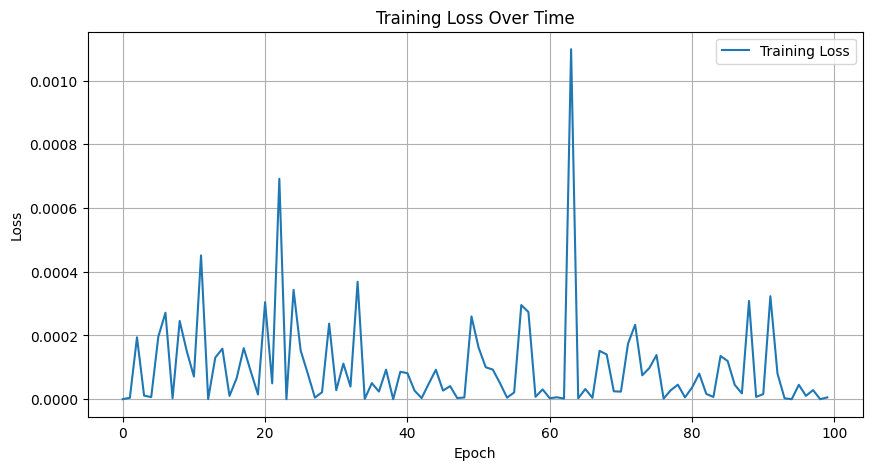

In [23]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Generating predictions for the dataset
model.eval()
predictions = []
for seq in X:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())

In [25]:
# Inverse transform the normalized values back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

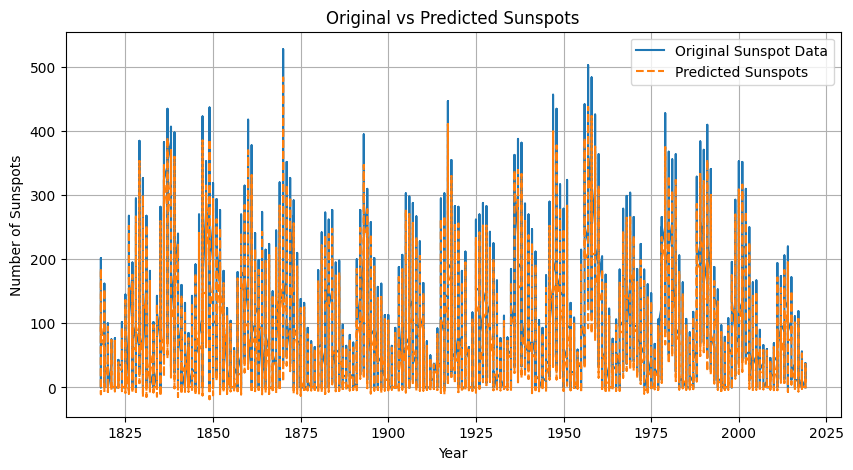

In [26]:
# Plot original data vs predictions
plt.figure(figsize=(10, 5))
plt.plot(data['Year'], sunspots, label='Original Sunspot Data')
plt.plot(data['Year'][window_size:], predictions, label='Predicted Sunspots', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.title('Original vs Predicted Sunspots')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [27]:
# Save the trained model
torch.save(model.state_dict(), 'sunspot_lstm_model_V2.pth')

Load the model

In [28]:
# Recreate the model architecture
model = SunspotLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)

# Load the saved model parameters
model.load_state_dict(torch.load('sunspot_lstm_model_V2.pth'))

# Set the model to evaluation mode (important for inference)
model.eval()

/tmp/ipykernel_73228/1588233602.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sunspot_lstm_model_V2.pth'))


SunspotLSTM(
  (lstm): LSTM(1, 50)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Use the Loaded Model for Prediction

In [29]:
# Generate predictions with the loaded model
predictions = []
for seq in X:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())